In [1]:
import pandas as pd
from pandas import Grouper, DataFrame
from pandas.plotting import autocorrelation_plot

import numpy as np
import os
from datetime import datetime
from typing import List

from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose


### Constantes

In [2]:
DIR_DATASET: str = os.path.join('datasets', 'dados-gerados')

DATASET_OEC_MPME = os.path.join(DIR_DATASET,  'oec_mpme.csv')

DAT_CORRENTE = datetime.today().strftime("%Y-%m-%d")

In [3]:
df_oec_mpme = pd.read_csv(DATASET_OEC_MPME, sep=';', decimal=',', parse_dates=True)

In [4]:
df_oec_mpme.index = pd.DatetimeIndex(df_oec_mpme.data_base)

In [5]:
df_oec_mpme["ano_mes"] = pd.DatetimeIndex(df_oec_mpme.data_base).strftime('%Y-%m')

In [6]:
df_oec_mpme.tail()

,ano,mes,data_base,desembolso,vendas,aprovacao,ind_atv_econ,tx_pre_prazo_medio,A_PRE_12,A_PRE_24,A_PRE_36,A_PRE_60,custo_bndes,ano_mes
data_base,,,,,,,,,,,,,,
2021-07-01,2021,7,2021-07-01,325.667389,13049.0,383.799488,138.68000,8.710928,6.439720,7.558042,8.027355,8.573779,9.310928,2021-07
2021-08-01,2021,8,2021-08-01,354.907705,14282.0,498.507464,138.06000,9.829825,6.986920,7.940970,8.345853,8.799348,10.429825,2021-08
2021-09-01,2021,9,2021-09-01,389.959495,12728.0,523.693027,137.42000,10.521768,7.998453,8.942889,9.373741,9.870852,11.121768,2021-09
2021-10-01,2021,10,2021-10-01,450.416064,12285.0,565.569456,136.87000,11.125235,8.729619,9.637906,10.057843,10.562139,11.725235,2021-10
2021-11-01,2021,11,2021-11-01,512.547902,11930.0,755.171106,137.28061,11.765139,9.849967,10.597666,10.854279,11.165322,12.365139,2021-11


---
### DESEMBOLSO

In [7]:
df_oec_mpme_desembolso = df_oec_mpme[['desembolso','ano','mes', 'ano_mes']]

<AxesSubplot:xlabel='data_base'>

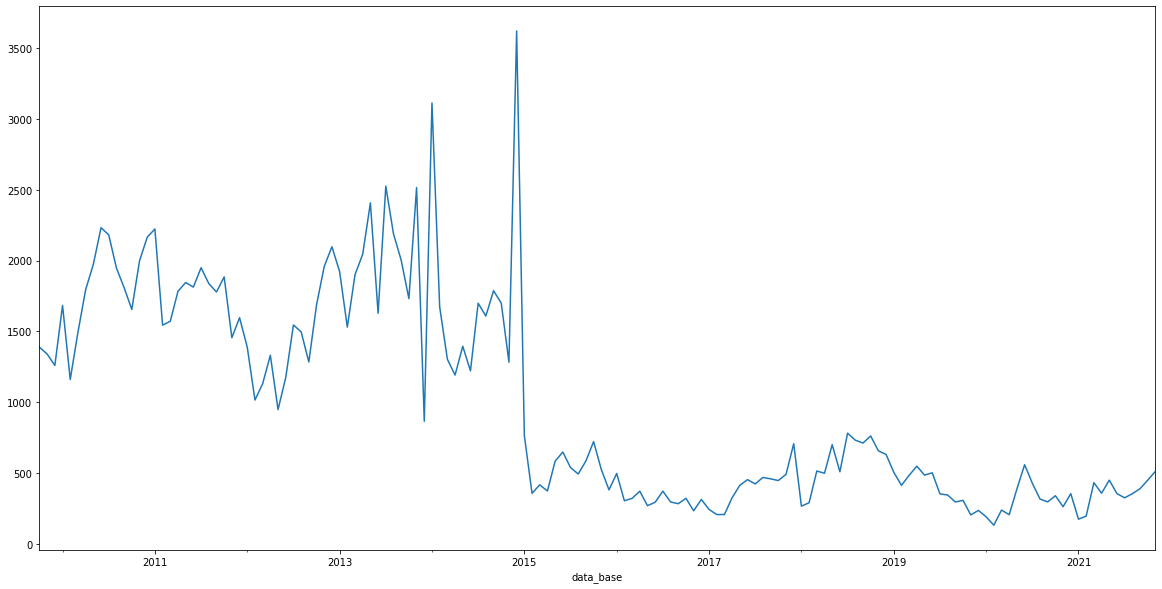

In [8]:
plt.figure(figsize=(20,10))
df_oec_mpme.desembolso.plot()

#### Agrupamento por ano

<AxesSubplot:xlabel='ano', ylabel='desembolso'>

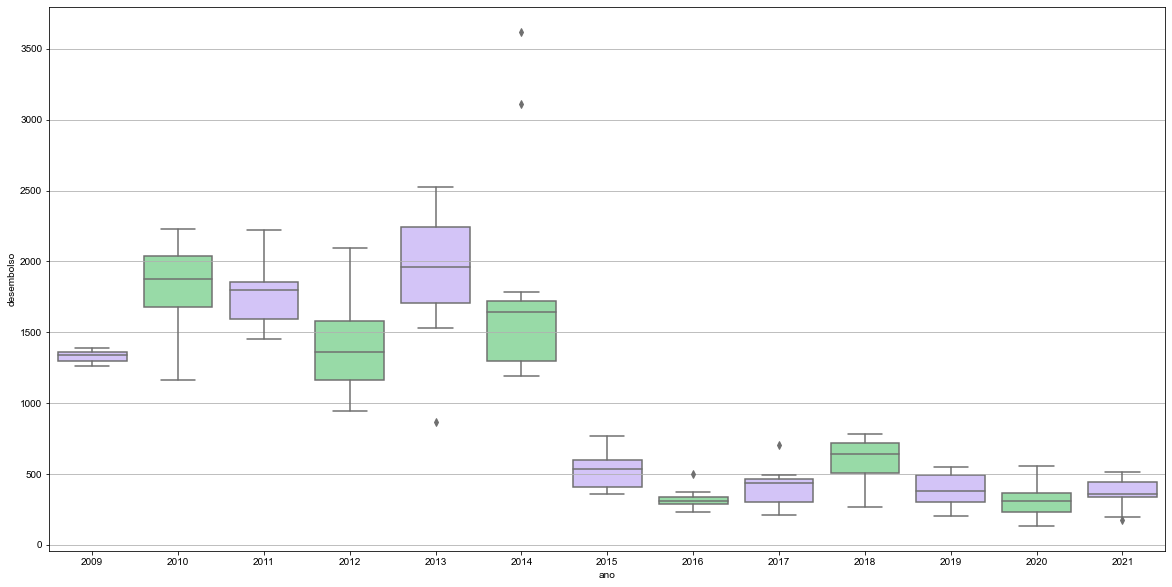

In [9]:
fig, ax = plt.subplots(figsize=(20, 10)) 
ax.yaxis.grid(True)
ax.xaxis.grid(False) 

sns.set_theme(style="white", palette="pastel")
sns.boxplot(x="ano", y="desembolso", palette=["m", "g"], data=df_oec_mpme_desembolso, ax=ax)

#### Histogram

<AxesSubplot:>

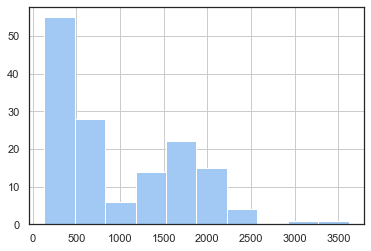

In [10]:
ser_desembolso = df_oec_mpme.desembolso
ser_desembolso.hist()

<AxesSubplot:ylabel='Density'>

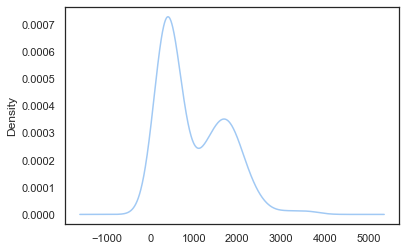

In [11]:
ser_desembolso.plot(kind='kde')

#### Moving Average

In [12]:
def moving_average(observations, window=3):
    '''returns the smoothed version of an array of observations.'''
    cumulative_sum = np.cumsum(observations, dtype=float)
    cumulative_sum[window:] = cumulative_sum[window:] - cumulative_sum[:-window]
    return cumulative_sum[window - 1:] / window

In [13]:
def run_sequence_plot_desembolso(x, y, title, xlabel="time", ylabel="valor desembolsado"):
    plt.figure(figsize=(20,10))
    plt.xticks(rotation='vertical')
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
    plt.plot(x, y, 'k-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3);

In [14]:
desembolso = df_oec_mpme_desembolso[["desembolso"]].to_numpy().squeeze()
desembolso_time = df_oec_mpme_desembolso[["ano_mes"]].to_numpy().squeeze()


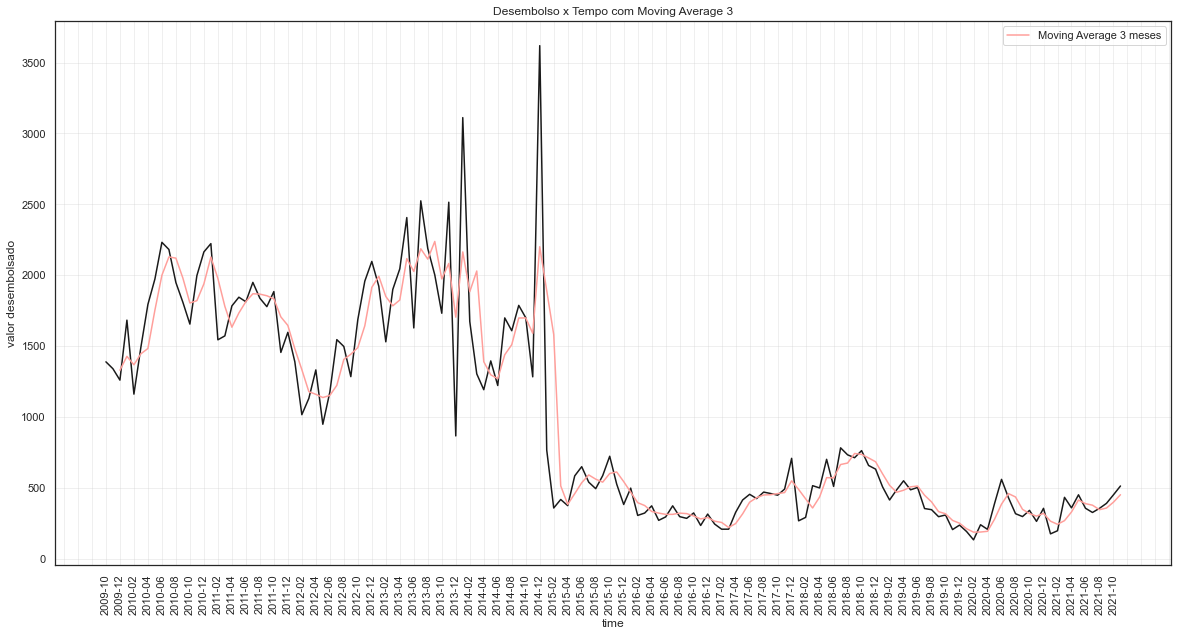

In [16]:
### Moving Average com Janela 3
window_ma_desembolso = 3
desembolso_ma = moving_average(desembolso, window_ma_desembolso)
run_sequence_plot_desembolso(desembolso_time, desembolso, f'Desembolso x Tempo com Moving Average {window_ma_desembolso}')
plt.plot(desembolso_time[window_ma_desembolso - 1:], desembolso_ma, 'r', label=f"Moving Average {window_ma_desembolso} meses")
plt.legend();

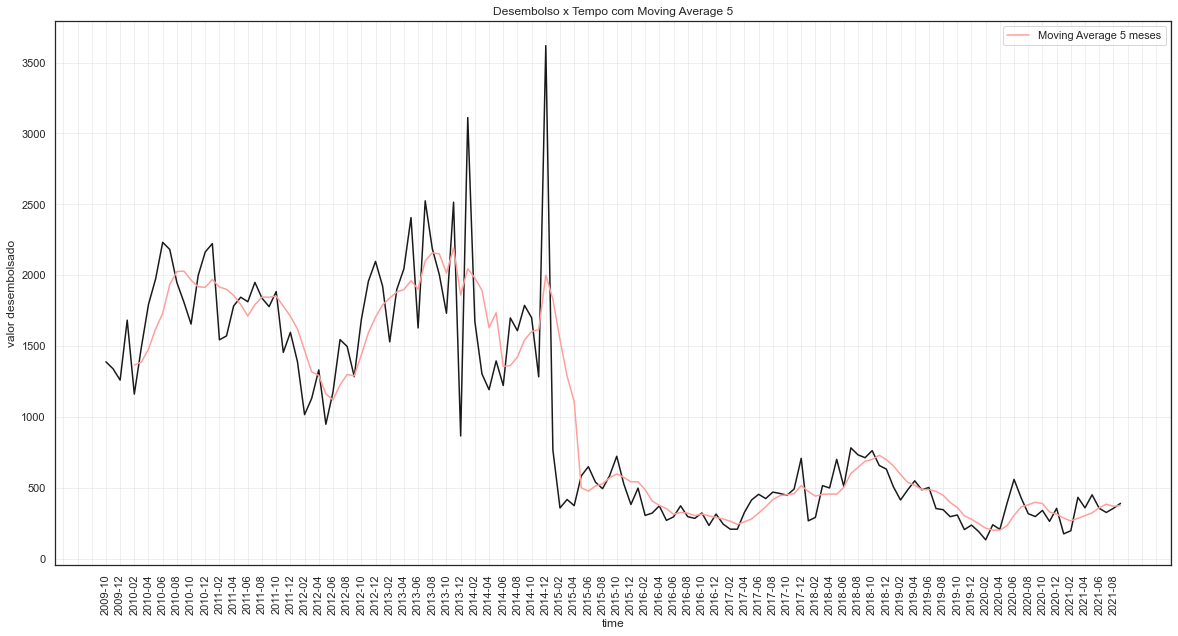

In [41]:
### Moving Average com Janela 5
window_ma_desembolso = 5
desembolso_ma = moving_average(desembolso, window_ma_desembolso)
run_sequence_plot_desembolso(desembolso_time, desembolso, f'Desembolso x Tempo com Moving Average {window_ma_desembolso}')
plt.plot(desembolso_time[window_ma_desembolso - 1:], desembolso_ma, 'r', label=f"Moving Average {window_ma_desembolso} meses")
plt.legend();

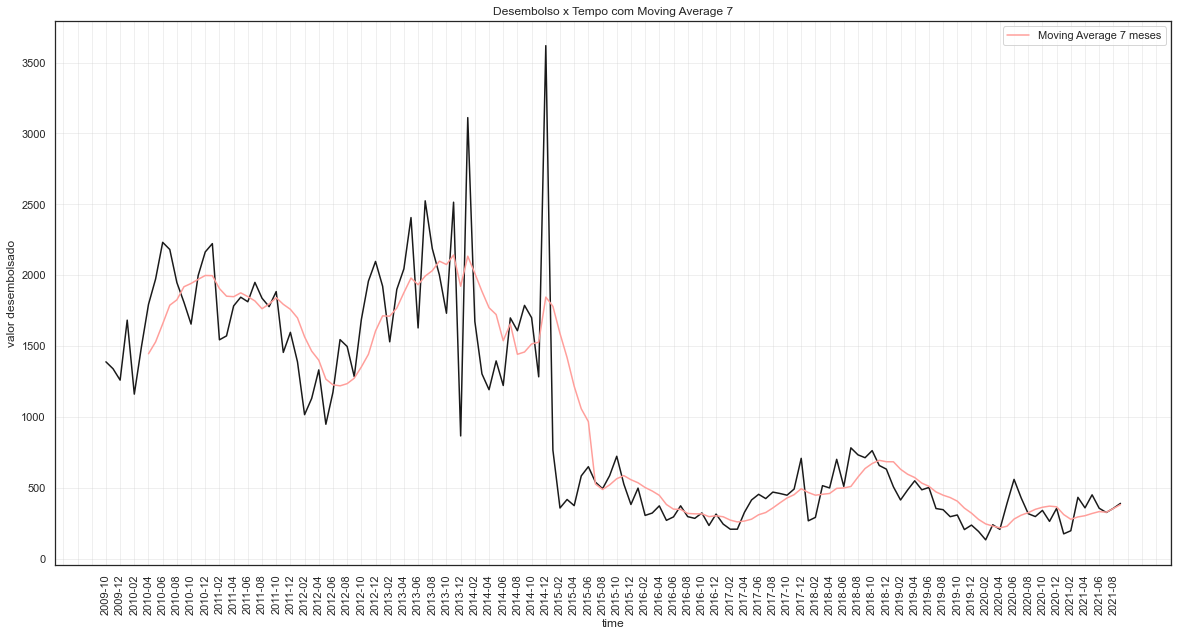

In [42]:
### Moving Average com Janela 7
window_ma_desembolso = 7
desembolso_ma = moving_average(desembolso, window_ma_desembolso)
run_sequence_plot_desembolso(desembolso_time, desembolso, f'Desembolso x Tempo com Moving Average {window_ma_desembolso}')
plt.plot(desembolso_time[window_ma_desembolso - 1:], desembolso_ma, 'r', label=f"Moving Average {window_ma_desembolso} meses")
plt.legend();

#### Decomposição

In [17]:
desembolso_decomposition = seasonal_decompose(x=desembolso, model='multiplicative', period=12)


In [18]:
desembolso_decomposition

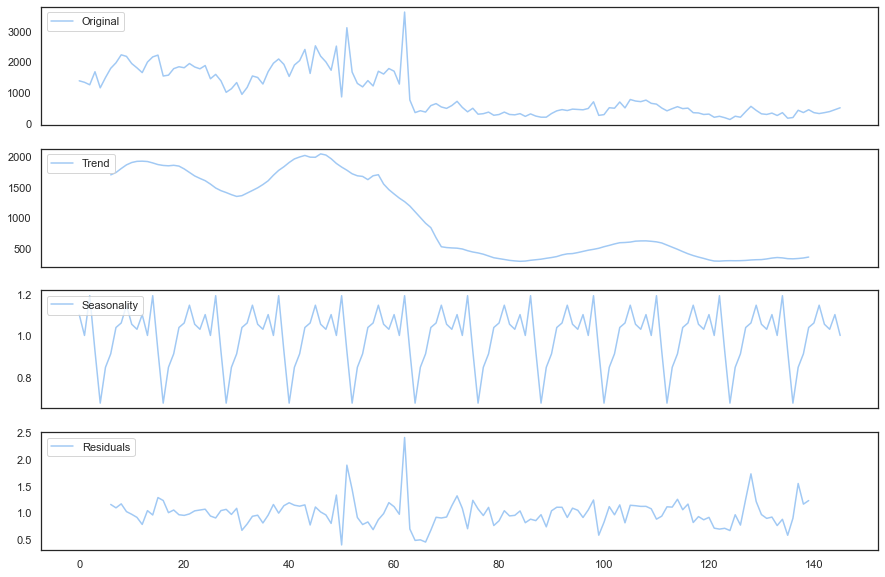

In [19]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(desembolso, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(desembolso_decomposition.trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(desembolso_decomposition.seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(desembolso_decomposition.resid, label='Residuals')
axes[3].legend(loc='upper left');

#### Autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

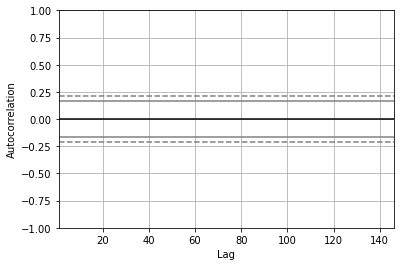

In [36]:
ser_desembolso = df_oec_mpme.desembolso
autocorrelation_plot(ser_desembolso)